In [277]:
import numpy as np
import matplotlib.pyplot as plt
import oqupy
from oqupy import operators as op
from scipy.linalg import eigh
import opt_einsum as oe
from scipy.linalg import expm


In [287]:


############################################################################################################
#SECTION 1: just do a load of stuff that is done in pt_tempo that looks useful, also take a load of constants 
#        and define the initial state the same as they do. Could be interesting to look at how changing these
#        affect the process tensor and fidelity and such
############################################################################################################
print(oqupy.__version__)

identity = np.array([[1, 0], [0, 1]])
sigma_x = oqupy.operators.sigma("x")
sigma_y = oqupy.operators.sigma("y")
sigma_z = oqupy.operators.sigma("z")
up_density_matrix = oqupy.operators.spin_dm("z+")
down_density_matrix = oqupy.operators.spin_dm("z-")
mixed_density_matrix = oqupy.operators.spin_dm("mixed")

omega_cutoff = 3.04
alpha = 0.126
temperature = 0.1309

initial_state=down_density_matrix




0.5.0


In [288]:
sigma_x

array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])

In [289]:

############################################################################################################
#SECTION 2: Here you are doing a quick tempo calculation similar to pt_tempo. I think its to simulate the 
#           non-Markovian quantum dynamics. In the end we calculate sigma_xyz which computes the length of
#           bloch sphere. IE how pure or coherent the qubit state is at each time step. This allows us to
#           check how strongly the environment 'decoheres' the system and how each control system (tries to)
#           keep the state pure.
#
#           For some reason I have also defined t for the whole document in this section.
############################################################################################################

def x_param(x,t):                                  #Here I just defined the h_x, h_y and h_z parameters as
    return x*t                                     #was defined in Eoin Butlers thesis. In the pt_tempo 
                                                   #tutorial they reduce it to a 2d problem by setting y=0                                           
def y_param(y,t):                                  #but I will not be doing that because I am silly and 
    return y*t                                     #I have a vague feeling doing it this way might be useful

def z_param(z,t):
    return z*t

t = np.linspace(0,10,1000)                           #Defining t for the whole file (this should probably be moved)

#def get_target_unitary(H, t):                        #making target unitary the hamiltonian I want
#    return expm(-1j * H * t / 2)


                                                   #Here I define the time dependant hamiltonian as I saw in 
#def time_dependant_hamiltonian(t):                 #Eoin Butler's thesis:
#    return (x_param(6,t) * sigma_x) + (y_param(4,t) * sigma_y) + (z_param(2,t) * sigma_z) 

#system = oqupy.TimeDependentSystem(time_dependant_hamiltonian) #set the system to be defined by this time
                                                               #dependant hamiltonian

correlations = oqupy.PowerLawSD(                    #This is the correlation function, you define why this is here
    alpha=alpha,                                    #in your notes if you are confused. Pretty much it is used to 
    zeta=3,                                         #characterize the interaction terms
    cutoff=omega_cutoff,
    cutoff_type='gaussian',
    temperature=temperature)
bath = oqupy.Bath(sigma_z/2, correlations)

tempo_parameters = oqupy.TempoParameters(dt=0.1, tcut=5.0, epsrel=10**(-4)) #sets the tempo parameters

#tempo_sys = oqupy.Tempo(system=system,                  #You probably need to figure out what this actually does
#                        bath=bath,                      #before you take it into the meeting
#                        initial_state=initial_state,
#                        start_time=0.0,
#                        parameters=tempo_parameters)
#dynamics = tempo_sys.compute(end_time=10
                             
                             
                             
#                             )

#t, s_x = dynamics.expectations(sigma_x, real=True)      #I know this is getting teh expectation values for the
#t, s_y = dynamics.expectations(sigma_y, real=True)      #dynamics of x, y and z and then using them to get the 
#t, s_z = dynamics.expectations(sigma_z, real=True)      #dynamics of the whole system.
#s_xyz = np.sqrt(s_x**2 + s_y**2 + s_z**2)           
#plt.plot(t, s_xyz, label=r'$\Delta = 0.0$')             #IE you are getting the length of the bloch vector at
#plt.xlabel(r'$t\,\Omega$')                              #time step and plotting them against each other to see
#plt.ylabel(r'$<\sigma_{xyz}>$')                         #when your given control values give you the most 
#plt.legend(loc=4)                                       #coherent system

#plt.show()



--> PT-TEMPO computation:
100.0%  100 of  100 [########################################] 00:00:02
Elapsed time: 2.1s
. done.


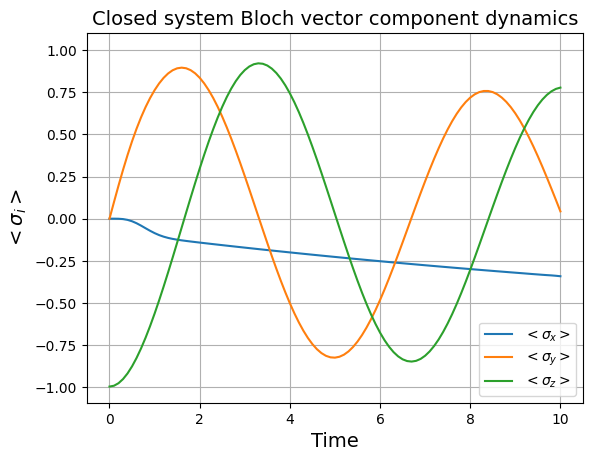

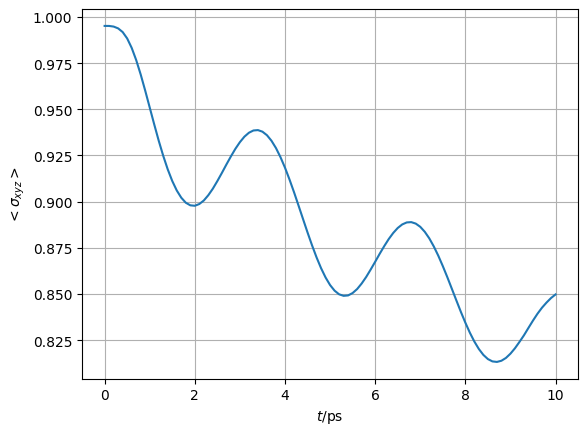

In [291]:

############################################################################################################
#SECTION 3: This is where the fun begins and trying to understand this almost made me hate physics 
#           
#           So pretty much what I have tried to do is follow pt_tempo as closely as possible, but rather than
#           having one "laser pulse detunings" that changed I put in five different values for my control 
#           parameters and created 125 different systems for which I can calculate their "coherentness".
############################################################################################################

process_tensor = oqupy.pt_tempo_compute(                   #Here I am creating the process tensor. Pretty
    bath=bath,                                             #much just copied what pt_tempo did but also not
    start_time=0.0,                                        #sure how else I would do it. Think this spits out
    end_time=10.0,                                          #a "SimpleProcessTensor"
    parameters=tempo_parameters
    )


h_xs = [1]                       #Define the set of control parameters I want to
h_ys = [0]                       #test for each h_i
h_zs = [0]

systems = []                                               #Creating the empty python lists that I will fill
                                                           #with the system objects

                                                           #Okay so here I am creating a time dependant hamiltonian
                                                           #similar to pt_tempo, except rather than one variable
for h_x in h_xs:                                           #changing, I am creating the hamiltonian for each 
    for h_y in h_ys:                                       #separate (hx, hy, hz) tuple
        for h_z in h_zs:
            def time_dependant_hamiltonian(t, h_x=h_x, h_y=h_y, h_z=h_z):
                return (h_x * (sigma_x/2)) + (h_y * (sigma_y/2)) + (h_z * (sigma_z/2))
            
            system = oqupy.TimeDependentSystem(time_dependant_hamiltonian)
            systems.append(system)
                                                           #Then of course need to append them to my empty list


s_xyz_list = []                                            #This next bit is plotting sigma_xyz for each separate
t_list = []                                                #system (IE you're working out how coherenty it is).
for system in systems:                                     #I'm not 100% sure on how this dynamics function works
    dynamics = oqupy.compute_dynamics(                     #and will need to study that for the report but pretty
        process_tensor=process_tensor,                     #much I created two empty lists for the time and 
        system=system,                                     #bloch vector lengths and then for each system (of
        initial_state=initial_state,                       # the 125) I think I worked out the dynamics using the
        start_time=0.0,                                    #process tensor 
        progress_type="silent")
    
    t, s_x = dynamics.expectations(sigma_x, real=True)     #Here then I do pretty much the same thing as before 
    t, s_y = dynamics.expectations(sigma_y, real=True)     #in the tempo bit, and then plot all of them on the
    t, s_z = dynamics.expectations(sigma_z, real=True)     #same graph
    s_xyz = np.sqrt(s_x**2 + s_y**2 + s_z**2)
    s_xyz_list.append(s_xyz)
    t_list.append(t)
    print(".", end="", flush=True)
print(" done.", flush=True)                                #Added this so that I could vaguel tell how many systems
                                                           #had been run (each dot is 1 system) and if it was
                                                           #still working

plt.plot(t, s_x,label='$<\sigma_{x}>$')
plt.plot(t, s_y,label='$<\sigma_{y}>$')
plt.plot(t, s_z,label='$<\sigma_{z}>$')
plt.ylim(top=1.1)
plt.title('Closed system Bloch vector component dynamics', fontsize=14)
plt.xlabel(r'Time', fontsize=14)
plt.ylabel(r'$<\sigma_{i}>$', fontsize=14)
plt.legend()
plt.grid()
plt.show()


plt.figure()

for t, s_xyz in zip(t_list, s_xyz_list):                   #This then plost all of them on the same graph
    plt.plot(t, s_xyz)
plt.xlabel(r'$t/$ps')
plt.ylabel(r'$<\sigma_{xyz}>$')
plt.grid()
plt.show()


In [292]:

############################################################################################################
#SECTION 4: Finally got it to work. So pretty much all I wanted to do here was extract the superoperator in 
#           Matrix form and this took me so goddamn long. My aim here was to check how the process acts on
#           a linearly independant and complete basis set for qubit density matrices. If I know how it acts
#           these four states then I can figure out how it acts on any state. Read some papers on quantum
#           tomography to get here.
############################################################################################################

d = 2                                               #Just making a note that I am working in a 2d hilbert
                                                    #to use later

rho_00 = np.array([[1, 0], [0, 0]])                 #Here I define my linearly independant and complete    
rho_01 = np.array([[0, 1], [0, 0]])                 #basis for for qubit density matrices
rho_10 = np.array([[0, 0],[1, 0]])            
rho_11 = np.array([[0, 0],[0, 1]])         
inputs = [rho_00, rho_01, rho_10, rho_11]

target_system = systems[0]                          #I have tried doing it for all 125 systems at once but it
                                                     #takes too damn long so I just pick any of the 125 


output_vecs = []                                     #Here we actually get the superoperator. Start by creating
for rho_in in inputs:                                #an empty list to put the output vectors in. Then using each
    dyn = oqupy.compute_dynamics(                    #of the input states I simulate their given time evolutions
        process_tensor=process_tensor,               #using the process tensor. Then the output is stored after
        system=target_system,                        #the full evolution. Then the matrix is flattened into a 
        initial_state=rho_in,                        #vector.
        start_time=0.0,
        progress_type="silent"                       #We know VEC(rho_out) = S * VEC(rho_in), and so by stacking
    )                                                #the output vectors, we are getting how S will act on any
                                                     #vectorized density matrix.

    rho_out = dyn.states[-1]                         #Here the state at the final time evolution is taken and then
    output_vecs.append(rho_out.flatten())            #flattened to get each of the output vectors

superoperator = np.column_stack(output_vecs) 

print(superoperator)



[[ 0.10834704+6.51590125e-13j -0.00233198+2.10104993e-02j
  -0.00233198-2.10104993e-02j  0.88538461+9.92181433e-13j]
 [-0.17057835+2.16313581e-02j -0.08864766+4.35521060e-13j
   0.59177086-7.29214777e-13j -0.17057835-2.16313581e-02j]
 [-0.17057835-2.16313581e-02j  0.59177086+7.27551228e-13j
  -0.08864766-4.35279561e-13j -0.17057835+2.16313581e-02j]
 [ 0.88538461-9.95085065e-13j -0.00233198-2.10104993e-02j
  -0.00233198+2.10104993e-02j  0.10834704-6.51068684e-13j]]


In [293]:

############################################################################################################
#SECTION 5: This is just my code that I had before with a few tweaks and a load of comments so that I know 
#           how to explain it better.
############################################################################################################

target_unitary_gate =  np.array([[0, 1j], [1j, 0]])
#np.array([[0, -1], [1, 0]])
 #defining my target unitary. Here I made it 
                                                                   #the Hadamard but it can be anything.

                                                      #Here I am defining my superoperator to Choi function.
                                                      #I get the dimensions of the superoperator first and then
                                                      #square root that for the hilbert space dimensions just to
                                                      #safe. Then I reshape the superoperator matrix into a rank
                                                      #4 tensor { E_(ij),(kl) --> E_ikjl }.
                                                      #Then the transpose function changes the tensor index from
def superoperator_to_choi(superoperator_matrix):      #(i,j,k,l) to (i,k,j,l) before the reshape function turns it
    d_sq = superoperator_matrix.shape[0]              #back into a 2D matrix.
    d = int(np.sqrt(d_sq))
    tensor = superoperator_matrix.reshape(d, d, d, d)
    choi_matrix = np.transpose(tensor, axes=(0, 2, 1, 3)).reshape(d_sq, d_sq)
    return choi_matrix

def extract_kraus_operators_from_choi_matrix(choi_matrix, minimum_eigenvalue_threshold=1e-10):
    eigenvalues, eigenvectors = np.linalg.eigh(choi_matrix)         #First the eigenvalues and eigenvectors are
    kraus_operator_set = []                                         #extracted. Then I create an empty list to 
    dim = int(np.sqrt(choi_matrix.shape[0]))                        #the Kraus operators. I then calculate the
                                                                    #dimension of the hilbert space using the 
                                                                    #Choi matrix.

    for i, val in enumerate(eigenvalues):                           #This loop processes each eigenvalue that is
        if val > minimum_eigenvalue_threshold:                      #non-zero (above the minimum threshold due to
            vec = eigenvectors[:, i].reshape((dim, dim), order='F') # potential errors) and reshapes the
            kraus_operator_set.append(np.sqrt(val) * vec)           #corresponding eigenvector into a dxd matrix
    return kraus_operator_set                                       #The matrix is then multiplied by the root of
                                                                    #the eigenvalue to get the Kraus operator.

def gate_fidelity_from_kraus_operators(kraus_ops, target_gate):     #This calculates the gate fidelity via the  
    U = np.array(target_gate, dtype=np.complex128)                  #given equation in the thesis. I start by
    U_dag = U.conj().T                                              #turning the target gate into a usable numpy
    n = U.shape[0]                                                  #array and calculate its hermitian conj.
    summand = np.zeros((n, n), dtype=np.complex128)                 #n stores the dimension of the system (again)
    trace_sum = 0                                                   #With the summand command I then initialized a
    for K in kraus_ops:                                             #zero matrix to accumulate the terms in the
        E = U_dag @ K                                               #summation, and I set the trace sum to zero
        summand += E @ E.conj().T                                   #to start also. Then for each Kraus operator
        trace_sum += abs(np.trace(E))**2                            #in the set I added the necessary operation
    return np.real((np.trace(summand) + trace_sum) / (n * (n + 1))) #from the equation and got the fidelity
                                                                    #as a real number


In [ ]:

############################################################################################################
#SECTION 6: Now I just have to put it all together and plot the average fidelity against time
############################################################################################################

time_steps = t[1:]                                          #skip the first time step so we analyze from first non trivial
fidelities = []

for t_end in time_steps:                                    #loops over the four basis states and calculates the evolution under the process tensor
    
    #target_unitary_gate =  get_target_unitary(sigma_x + sigma_y, t_end)
    
    output_vecs = []
    for rho_in in [rho_00, rho_01, rho_10, rho_11]:
        dyn = oqupy.compute_dynamics(
            process_tensor=process_tensor,
            system=target_system,
            initial_state=rho_in,
            start_time=0.0,
            progress_type="silent"
        )
        idx = np.argmin(np.abs(dyn.times - t_end))          #extract the state at the desired time, idx gets the index at the nearest time step
        rho_out = dyn.states[idx]
        output_vecs.append(rho_out.flatten())               #this converts it into a 4 element vector

    superoperator = np.column_stack(output_vecs)            #builds the superoperator etc. at each time step.
    choi_matrix = superoperator_to_choi(superoperator)
    kraus_ops = extract_kraus_operators_from_choi_matrix(choi_matrix)
    fidelity = gate_fidelity_from_kraus_operators(kraus_ops, target_unitary_gate)
    fidelities.append(fidelity)
    print(f"t = {t_end:.2f} → Fidelity = {fidelity:.5f}")





t = 0.10 → Fidelity = 0.33500
t = 0.20 → Fidelity = 0.33998
t = 0.30 → Fidelity = 0.34822
t = 0.40 → Fidelity = 0.35965
t = 0.50 → Fidelity = 0.37414
t = 0.60 → Fidelity = 0.39155
t = 0.70 → Fidelity = 0.41172
t = 0.80 → Fidelity = 0.43443
t = 0.90 → Fidelity = 0.45946
t = 1.00 → Fidelity = 0.48657
t = 1.10 → Fidelity = 0.51547
t = 1.20 → Fidelity = 0.54588
t = 1.30 → Fidelity = 0.57750
t = 1.40 → Fidelity = 0.61001
t = 1.50 → Fidelity = 0.64309
t = 1.60 → Fidelity = 0.67640
t = 1.70 → Fidelity = 0.70961
t = 1.80 → Fidelity = 0.74240
t = 1.90 → Fidelity = 0.77443
t = 2.00 → Fidelity = 0.80538
t = 2.10 → Fidelity = 0.83495
t = 2.20 → Fidelity = 0.86283
t = 2.30 → Fidelity = 0.88876
t = 2.40 → Fidelity = 0.91246
t = 2.50 → Fidelity = 0.93371
t = 2.60 → Fidelity = 0.95230
t = 2.70 → Fidelity = 0.96802
t = 2.80 → Fidelity = 0.98074
t = 2.90 → Fidelity = 0.99032
t = 3.00 → Fidelity = 0.99666
t = 3.10 → Fidelity = 0.99971
t = 3.20 → Fidelity = 0.99943
t = 3.30 → Fidelity = 0.99583
t = 3.40 →

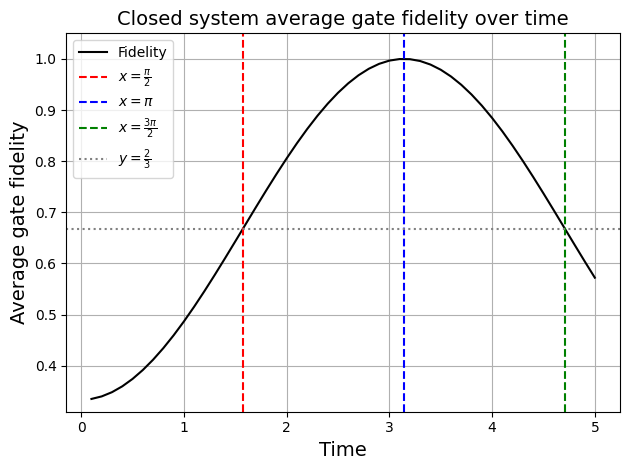

In [ ]:
plt.plot(time_steps, fidelities, color='black', label='Fidelity')  
plt.xlabel("Time", fontsize=14)
plt.ylabel(r"Average gate fidelity", fontsize=14)

plt.axvline(x=np.pi/2, color='red', linestyle='--', label=r'$x = \frac{\pi}{2}$')
plt.axvline(x=np.pi, color='blue', linestyle='--', label=r'$x = \pi$')
plt.axvline(x=3*np.pi/2, color='green', linestyle='--', label=r'$x = \frac{3\pi}{2}$')

plt.axhline(y=2/3, color='gray', linestyle=':', label=r'$y = \frac{2}{3}$')


plt.ylim(top=1.05, bottom = 0.31)
plt.title("Closed system average gate fidelity over time", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [294]:
tcut_values = np.arange(0.1, 5.1, 0.1)
fidelity_1 = []
fidelity_2 = []
fidelity_3 = []
fidelity_4 = []
fidelity_5 = []

for tcut in tcut_values:
    print(f"Computing for tcut = {tcut:.1f}...", end=" ", flush=True)

    # Define new tempo parameters for this tcut
    tempo_params = oqupy.TempoParameters(dt=0.1, tcut=tcut, epsrel=1e-4)

    # Compute new process tensor
    pt = oqupy.pt_tempo_compute(
        bath=bath,
        start_time=0.0,
        end_time=5.0,
        parameters=tempo_params
    )

    # Use your existing function
    def compute_fidelity_at_time(process_tensor, system, t_target):

        target_unitary_gate =  get_target_unitary(sigma_x, t_target)

        output_vecs = []
        for rho_in in [rho_00, rho_01, rho_10, rho_11]:
            dyn = oqupy.compute_dynamics(
                process_tensor=process_tensor,
                system=system,
                initial_state=rho_in,
                start_time=0.0,
                progress_type="silent"
            )
            idx = np.argmin(np.abs(dyn.times - t_target))
            rho_out = dyn.states[idx]
            output_vecs.append(rho_out.flatten())

        S = np.column_stack(output_vecs)
        choi = superoperator_to_choi(S)
        kraus_ops = extract_kraus_operators_from_choi_matrix(choi)
        return gate_fidelity_from_kraus_operators(kraus_ops, target_unitary_gate)

    # Get fidelity at pi/2 and 3pi/2
    f1 = compute_fidelity_at_time(pt, target_system, 1)
    f2 = compute_fidelity_at_time(pt, target_system, 2)
    f3 = compute_fidelity_at_time(pt, target_system, 3)
    f4 = compute_fidelity_at_time(pt, target_system, 4)
    f5 = compute_fidelity_at_time(pt, target_system, 5)

    fidelity_1.append(f1)
    fidelity_2.append(f2)
    fidelity_3.append(f3)
    fidelity_4.append(f4)
    fidelity_5.append(f5)
    print(f"Done. Fid1 = {f1:.5f}, Fid2 = {f2:.5f}, Fid3 = {f3:.5f}, Fid4 = {f4:.5f}, Fid5 = {f5:.5f}")

Computing for tcut = 0.1... --> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.1s
Done. Fid1 = 0.95236, Fid2 = 0.90727, Fid3 = 0.86628, Fid4 = 0.83084, Fid5 = 0.79919
Computing for tcut = 0.2... --> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.1s
Done. Fid1 = 0.93449, Fid2 = 0.87277, Fid3 = 0.81884, Fid4 = 0.77519, Fid5 = 0.73818
Computing for tcut = 0.3... --> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.2s
Done. Fid1 = 0.92640, Fid2 = 0.85685, Fid3 = 0.79717, Fid4 = 0.75032, Fid5 = 0.71165
Computing for tcut = 0.4... --> PT-TEMPO computation:
100.0%   50 of   50 [########################################] 00:00:00
Elapsed time: 0.2s
Done. Fid1 = 0.92726, Fid2 = 0.85861, Fid3 = 0.79957, Fid4 = 0.75301, Fid5 = 0.71445
Computing for tcut = 0.5... --> PT-TEMPO computation:
100.0%   50 of   50 [#####

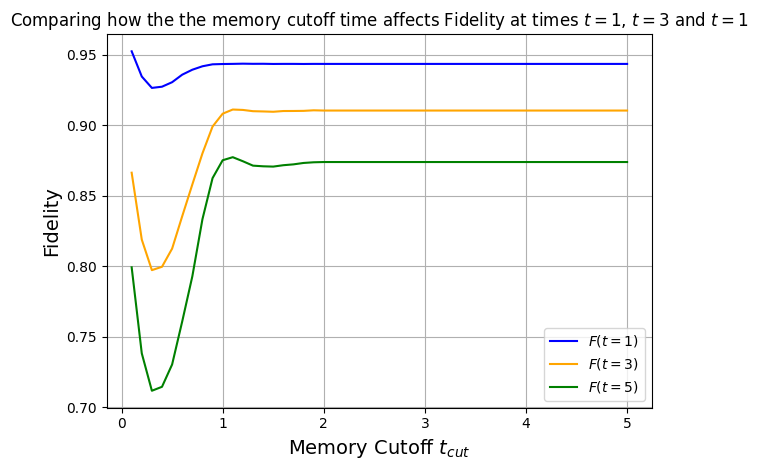

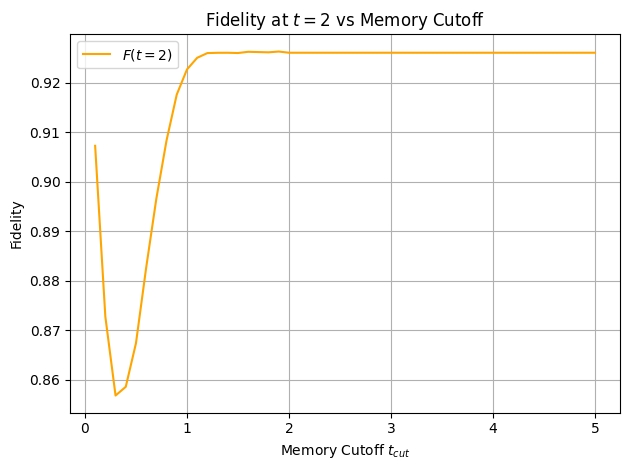

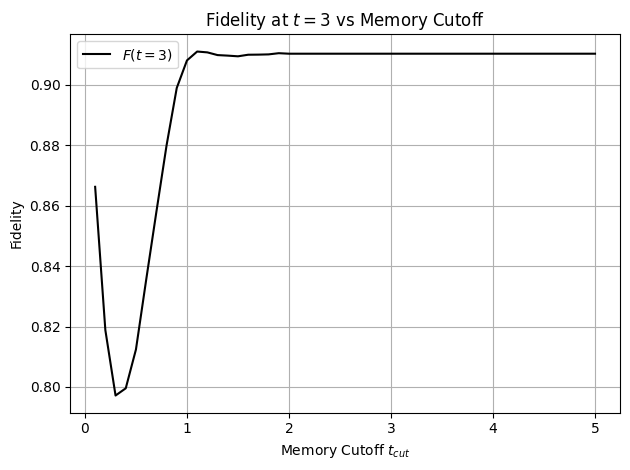

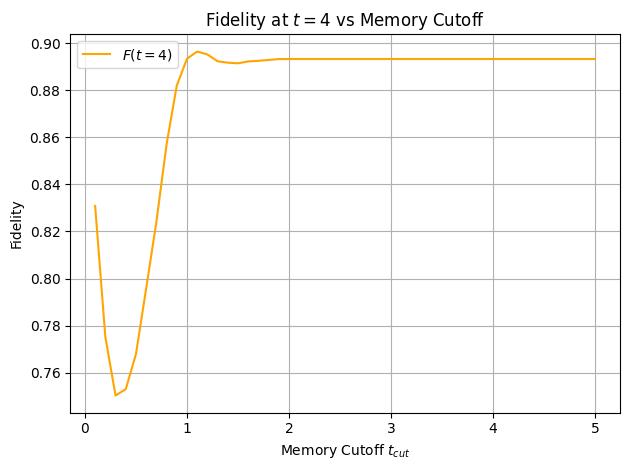

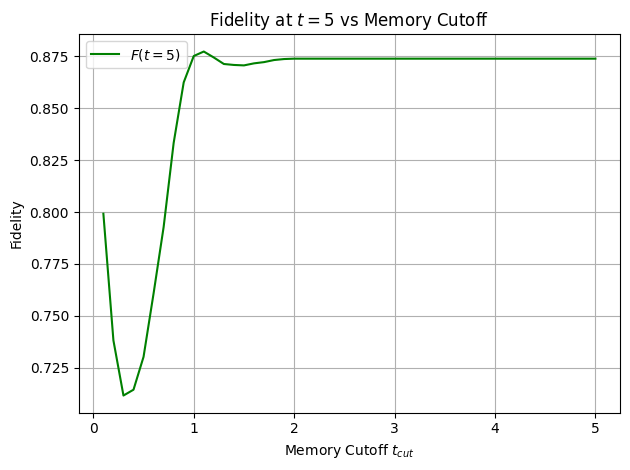

In [295]:

plt.figure()
plt.plot(tcut_values, fidelity_1, label=r'$F(t = 1)$', color='blue')
plt.plot(tcut_values, fidelity_3, label=r'$F(t = 3)$', color='orange')
plt.plot(tcut_values, fidelity_5, label=r'$F(t = 5)$', color='green')

plt.xlabel("Memory Cutoff $t_{cut}$", fontsize=14)
plt.ylabel("Fidelity", fontsize=14)
plt.title("Comparing how the the memory cutoff time affects Fidelity at times $t = 1$, $t = 3$ and $t = 1$", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tcut_values, fidelity_2, label=r'$F(t = 2)$', color='orange')
plt.xlabel("Memory Cutoff $t_{cut}$")
plt.ylabel("Fidelity")
plt.title("Fidelity at $t = 2$ vs Memory Cutoff")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tcut_values, fidelity_3, label=r'$F(t = 3)$', color='black')
plt.xlabel("Memory Cutoff $t_{cut}$")
plt.ylabel("Fidelity")
plt.title("Fidelity at $t = 3$ vs Memory Cutoff")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tcut_values, fidelity_4, label=r'$F(t = 4)$', color='orange')
plt.xlabel("Memory Cutoff $t_{cut}$")
plt.ylabel("Fidelity")
plt.title("Fidelity at $t = 4$ vs Memory Cutoff")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tcut_values, fidelity_5, label=r'$F(t = 5)$', color='green')
plt.xlabel("Memory Cutoff $t_{cut}$")
plt.ylabel("Fidelity")
plt.title("Fidelity at $t = 5$ vs Memory Cutoff")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()